# EAE 127 - Project 6: Vortex Panel Method


Chung Yin Leung (998238900)

---

Imports and setup code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
%matplotlib inline

---

## Introduction

In this project, a first order vortex panel method is used to examine lifting flow over an airfoil, and its accuracy is examined. Different methods of calculating the lift coefficient is compared with each other, and the effect of neglecting the tangency condition is examined by looking at the lift coefficient and the streamline plot. Results of the surface pressure distribution is also compared to XFOIL results. Finally, the lift curve slope from the vortex panel method is compared to the lift curve slope from Thin Airfoil Theory.

---

### Problem 1: Calculating Lift With Vortex Panels

#### Approach

A first order vortex panel method is used to model lifting flow over a NACA 0012 airfoil. The geometry of the airfoil is first discretized into segments in a counterclockwise fashion. The segments are defined as vortex panels. Applying the tangency condition to each vortex panel generates N equations with N unknown vortex strength. To enable realistic flow behavior, the Kutta condition must be enforced. For the first order method, the Kutta condition is applied by replacing one of the N equations. This results in N equations for the vortex strength distribution of the panels. Using the vortex strength distribution, the tangential velocity at each panel can be calculated. Applying Bernoulli's equation with the tangential velocities allows the surface pressure distribution to be calculated over the airfoil.

With the surface pressure distribution, the lift coefficient can be calculated by finding the normal force coefficient and axial force coefficient. Both requires the surface pressure distribution to be integrated. Then the lift coefficient can be calculated by using the angle of attack. The lift coefficient can also be calculated by using the Kutta-Joukowski Theorem and the circulation. The circulation can be calculated using any closed loop around the set of vortex panels and integrating the velocity vector along the clockwise direction of the closed loop. It can also be calculated by summing up the vortex strengths of each panel.

#### Equations

The Kutta Conditon can be defined by the following equations, where 1 and N are the panels connected together at the point of the trailing edge.

$$
V_1 = V_N
$$

$$
\gamma(TE) = V_1 - V_N = 0
$$

Enforcing the Kutta Condition for a set of vortex panels, the vortex strengths of the panels connected by the trailing edge's point are:

$$
\gamma_1 = -\gamma_N
$$

The tangency condition requires the normal velocity at the control points of each panel to be 0 such that

$$
V_{n,control} = V_{n,freestream} + V_{n,panels} = 0
$$

$$
V_{n, panels} = -V_{n, freestream}
$$

The normal component of the freestream velocity at a panel is given by the following.

$$
V_{n,freestream} = V_\infty \cos(\alpha - \beta_i)
$$

The velocity potential of the vortex sheet is given by the following equation.

$$
\phi_{panels}(x,y) = -\sum_{j=1}^{n} \frac{\gamma_j}{2\pi} \int_j \tan^{-1} \left(\frac{y - y_j}{x - x_j}\right) \rm{d}s_j
$$

Using the velocity potential, the normal velocity contribution of the panels to a control point can be found as the following equation:

$$
V_{n,panels} = \frac{\delta}{\delta n_i} \left(\phi_{panels}(x_i,y_i)\right) = -\sum_{j=1}^{N} \frac{\gamma_j}{2\pi} 
\int_j \frac{
\left(x_i - x_j\right) \sin \beta_i - \left(y_i - y_j\right) \cos \beta_i}
{
\left(x_i - x_j\right)^2+\left(y_i - y_j\right)^2} \rm{d}s_j
$$

And the following equation results for the vortex strengths of the panels in order to satisfy the tangency condition:

$$
\boldsymbol{\rm A} \vec{\gamma} = \vec{b}
$$

where the i-th entry in $\vec{\gamma}$ contains the i-th panel's vortex strength, and 

$$
A_{i,i} = 0
$$

$$
A_{i,j} = -\frac{1}{2\pi} \int_j \frac{
\left(x_i - x_j\right) \sin \beta_i - \left(y_i - y_j\right) \cos \beta_i}
{
\left(x_i - x_j\right)^2+\left(y_i - y_j\right)^2} \rm{d}s_j
$$

$$
b_i = -V_\infty \cos(\alpha - \beta_i)
$$

But to employ the Kutta Condition, an i-th row must have 
$$
A_{i,1} = 1
$$

$$
A_{i,N} = 1
$$

$$
b_i = 0
$$

where the other entries in the i-th row are zeros.

In [2]:
###############################################################################
### SOLVE PANEL SYSTEM ########################################################
###############################################################################

def SolveVorticity(panels, airfoil, display=0):
    """Solve for the source strength distributions and vortex sheet such that
    the tangency condition and the Kutta condition are satified.
    """

    def KuttaCondition(panels):
        """
        KUTTA CONDITION:
            Tangential velocities of upper TE (Panel 1) and lower TE (Panel N) are
        the same assuming bernoulli and same pressure because shared point (TE).
            Vorticity of a vortex sheet: gamma = utop - ubot (Anderson eqn 4.8).
        Since utop = ubot for TE, ------> gammaTE = 0 <--------- that's the K.C.
        """

        n_panel = len(panels)
        #To make vorticity of TE top and TE bottom panel add to zero,
        #row entry will be array of zeros with first and last entry as 1's,
        #thus only accounting for TE top and bottom.  set equal to zero for KC
        x = np.zeros(n_panel)
        x[0], x[-1] = 1, 1
        return x

    def TangencyCondition(panels, airfoil):
        """Array accounting for vortex contribution from each panel.
        panels --> array of panels
        """
        n_panel = len(panels)
        #Populate matrix of system of equations for each panel
        size = (n_panel, n_panel)
        A = np.zeros(size)
        #Fill diagonal with term for each panel's contribution to itself
        np.fill_diagonal(A, 0.0)
        #Fill matrix with each panel's contribution to every other panel
        for i, pi in enumerate(panels):
            for j, pj in enumerate(panels):
                if i != j:
                    A[i,j] = PanelIntegral(pi, pj, 'normal vortex')

        #Replace Missing Panel with Kutta Condition
        A[airfoil.ihole,:] = KuttaCondition(panels)

        return A

    #Make system to solve

    """
         |   vortex contributions    |  vorticies  | freestream contribution |

          j=1 j=2 . .  . . j=N-1 j=N
    i=1  [ 0                        ]   [ gamma1  ]   [ -Vinf*cosBeta1 ]
         [                vortex    ]   [         ]   [ -Vinf*cosBeta2 ]
    i=2  [     0         contrib    ]   [ gamma2  ]   [        .       ]
     .   [       .                  ]   [    .    ]   [        .       ]
     .   [                          ]   [    .    ]   [                ]
    i=ik [ 1   0  . .  . .  0   1   ] * [ gammaiK ] = [        0       ]<--K.C.
     .   [                          ]   [    .    ]   [                ]
     .   [                .         ]   [    .    ]   [                ]
   i=N-1 [   vortex          0      ]   [ gammaN-1]   [        .       ]
         [   contrib                ]   [         ]   [        .       ]
    i=N  [                        0 ]   [ gammaN  ]   [ -Vinf*cosBetaN ]


                    [A]           *       [gam]      =        [b]

            NOTE:  ik is index of missing panel to enforce kutta condition
    """

    n_panel = len(panels)
    #CONTRIBUTION OF EACH PANEL TO FLOW TANGENCY OF EACH CONTROL POINT
    A = TangencyCondition(panels, airfoil)
    #Right Hand Side
    b = np.empty(n_panel, dtype=float)
    for i, p in enumerate(panels):
        #FREESTREAM FLOW IN NORMAL DIR, MUST BE CANCELED BY VORTEX CONTRIBUTIONS
        b[i] = -airfoil.Vinf * np.cos(airfoil.alpha - p.beta)
    #KUTTA CONDITION (gamTE = 0)
    b[airfoil.ihole] = 0

    #SOLVE SYSTEM
    gam = np.linalg.solve(A, b)

    #assign variables
    for i, p in enumerate(panels):
        p.gamma = gam[i]
    
    if display != 0:
        #Check for Kutta Condition
        print('gamma1 =', panels[0].gamma,
              'gammaN =', panels[-1].gamma,
              'gamma1 + gammaN =', panels[0].gamma + panels[-1].gamma)

    return panels

In [3]:
def PanelIntegral(pi, pj, dir):
    """Evaluate contribution of panel at center of another panel.
    pj --> panel where contribution is calculated
    pj --> panel from which contribution is calculated
    direction of component and type of contribution --> 'normal source',
                                                        'tangent vortex',
                                                        etc
    """
    if dir=='normal source':
        #derivatives with respect to: normal direction for sources contribution
        dxd_, dyd_ = np.cos(pi.beta), np.sin(pi.beta)
        coeff = 1
    elif dir=='normal vortex':
        #derivatives with respect to: normal direction for vortex contribution
            #(opposite of source)
            #so to be explicitly clear: the variables dxd_, dyd_ are switched,
                #so this is technically incorrect notation
        dxd_, dyd_ = np.sin(pi.beta), np.cos(pi.beta)
        coeff = -1
    elif dir=='tangent source':
        #derivatives with respect to: tangential direction for sources
        dxd_, dyd_ = -np.sin(pi.beta), np.cos(pi.beta)
        coeff = 1
    elif dir=='tangent vortex':
        #derivatives with respect to: tangential direction for vorticity
        #(again, signs are technically incorrect to make function work)
        dxd_, dyd_ = np.cos(pi.beta), -np.sin(pi.beta)
        coeff = -1
    #function to integrate
    def func(s):
        #x-coord of s-vector along panel
        xjsj = pj.xa - np.sin(pj.beta)*s
        #y-coord of s-vector along panel
        yjsj = pj.ya + np.cos(pj.beta)*s
        return (coeff*0.5/np.pi)*((pi.xc - xjsj)*dxd_ + coeff*(pi.yc - yjsj)*dyd_)/((pi.xc - xjsj) ** 2 + (pi.yc - yjsj) ** 2)

    #Integrate along length of panel
    return integrate.quad(lambda s:func(s), 0., pj.length)[0]

Using the A matrix and b vector from above, the normal velocity at the control points of each panel can be calculated using the following equation:

$$
\vec{V_n} = \boldsymbol{\rm A} \vec{\gamma} - \vec{b} 
$$

where the i-th entry in $\vec{\gamma}$ contains the i-th panel's vortex strength, the i-th entry in $\vec{V_n}$ contains the normal velocity at the control point of the i-th panel, and 

$$
A_{i,i} = 0
$$

$$
A_{i,j} = -\frac{1}{2\pi} \int_j \frac{
\left(x_i - x_j\right) \sin \beta_i - \left(y_i - y_j\right) \cos \beta_i}
{
\left(x_i - x_j\right)^2+\left(y_i - y_j\right)^2} \rm{d}s_j
$$

$$
b_i = -V_\infty \cos(\alpha - \beta_i)
$$

In [4]:
def NormalVel(panels, airfoil, show_plot=0):
    """Calculate velocity normal to body surface, should be zero.

    panels --> array of panels
    method --> 'integrate' (integrate contributions from all panels),
                'gamma' (panel surface velocity equals panel vorticity)
    """
    n_panel = len(panels)

    #Populate matrix of system of equations for each panel
    size = (n_panel, n_panel)
    A = np.zeros(size)
    #Fill diagonal with term for each panel's contribution to itself
    np.fill_diagonal(A, 0.0)
    #Fill matrix with each panel's contribution to every other panel
    for i, pi in enumerate(panels):
        for j, pj in enumerate(panels):
            if i != j:
                #tangential vel. contrib. at all points from all vortex dists.
                A[i,j] = PanelIntegral(pi, pj, 'normal vortex')

    #Populate b vector
    b = airfoil.Vinf * np.cos([airfoil.alpha - p.beta for p in panels])
    #vector of vorticity distribution (all panel gammas are the same)
    gam = [p.gamma for p in panels]
    #solve system for normal velocities
    vn = np.dot(A, gam) + b
    for i, panel in enumerate(panels):
        panel.vn = vn[i]

    #dont plot if show_plot=0
    if show_plot != 0:
        #Plot Surface Normal Velocity
        size = 8
        plt.figure(figsize = (size,size))
        # plt.xlim(0, 360)
        plt.title('Normal Velocity Over ' + airfoil.title, fontsize=txt_ttl)
        plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
        plt.ylabel('$V_N$', fontsize=txt_lbl)
        plt.plot([p.xc for p in panels], vn)
        plt.show()

Simlarly for the tangential velocity at the control points, the tangential velocity contributed by the panels can be found from the velocity potential:

$$
V_{t,panels} = \frac{\delta}{\delta t_i} \left(\phi_{panels}(x_i,y_i)\right) = -\sum_{j=1}^{N} \frac{\gamma_j}{2\pi} 
\int_j \frac{
\left(x_i - x_j\right) \cos \beta_i + \left(y_i - y_j\right) \sin \beta_i}
{
\left(x_i - x_j\right)^2+\left(y_i - y_j\right)^2} \rm{d}s_j
$$

And the freestream velocity contribution at the control points is given as follows:

$$
V_{t,freestream} = V_\infty \sin(\alpha - \beta_i)
$$

Then the total tangential velocity at a control point is:

$$
V_{t,control} = V_\infty \sin(\alpha - \beta_i) -\sum_{j=1}^{N} \frac{\gamma_j}{2\pi} 
\int_j \frac{
\left(x_i - x_j\right) \cos \beta_i + \left(y_i - y_j\right) \sin \beta_i}
{
\left(x_i - x_j\right)^2+\left(y_i - y_j\right)^2} \rm{d}s_j
$$

In matrix notation, equations turn into the following:

$$
\vec{V_t} = \vec{d} + \boldsymbol{\rm C} \vec{\gamma} 
$$

where the i-th entry in $\vec{\gamma}$ contains the i-th panel's vortex strength, the i-th entry in $\vec{V_t}$ contains the tangential velocity at the control point of the i-th panel, and 

$$
C_{i,i} = -0.5
$$

$$
C_{i,j} = -\frac{1}{2\pi} 
\int_j \frac{
\left(x_i - x_j\right) \cos \beta_i + \left(y_i - y_j\right) \sin \beta_i}
{
\left(x_i - x_j\right)^2+\left(y_i - y_j\right)^2} \rm{d}s_j
$$

$$
d_i = V_\infty \sin(\alpha - \beta_i)
$$

In [5]:
def TangentVel(panels, airfoil, show_plot=0):
    """Calculate tangential velocity

    panels --> array of panels
    method --> 'integrate' (integrate contributions from all panels),
                'gamma' (panel surface velocity equals panel vorticity)
    """
    n_panel = len(panels)

    #Populate matrix of system of equations for each panel
    size = (n_panel, n_panel)
    A = np.zeros(size)
    #Fill diagonal with term for each panel's contribution to itself
    np.fill_diagonal(A, -0.5)
    #Fill matrix with each panel's contribution to every other panel
    for i, pi in enumerate(panels):
        for j, pj in enumerate(panels):
            if i != j:
                #tangential vel. contrib. at all points from all vortex dists.
                A[i,j] = PanelIntegral(pi, pj, 'tangent vortex')

    #Populate b vector
    b = airfoil.Vinf * np.sin([airfoil.alpha - p.beta for p in panels])
    #vector of vorticity distribution (all panel gammas are the same)
    gam = [p.gamma for p in panels]
    #solve system for tangential velocities
    vt = np.dot(A, gam) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]
        
    #dont plot if show_plot=0
    if show_plot != 0:
        #Plot Surface Tangential Velocity
        size = 8
        plt.figure(figsize = (size,size))
        plt.title('Tangential Velocity Over ' + airfoil.title, fontsize=txt_ttl)
        plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
        plt.ylabel('$V_t$', fontsize=txt_lbl)
        plt.plot([p.xc for p in panels if p.surf=='upper'], [p.vt for p in panels if p.surf=='upper'], label = 'Upper surface')
        plt.plot([p.xc for p in panels if p.surf=='lower'], [p.vt for p in panels if p.surf=='lower'], label = 'Lower surface')
        plt.legend(loc='best')
        plt.show()

Assuming that the normal velocity at the "missing panel" is also 0, then the following equation gives the surface pressure distribution across the panels' surfaces:

$$C_{p_i} = 1-\left(\frac{V_{t, i}}{V_\infty}\right)^2$$

In [6]:
def Panels_Cp(panels, airfoil, show_plot = 0):
    """Evaluates the coefficient of pressure at each panel and stores in each Panel object.
    
    Arguments
    ---------
    panels -- a list of Panel objects
    
    """
    # calculates the surface pressure coefficient
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/airfoil.Vinf)**2

    #dont plot if show_plot=0
    if show_plot != 0:
        #Plot Surface Pressure coefficient
        size = 8
        plt.figure(figsize = (size,size))
        plt.title('Surface Pressure Over ' + airfoil.title, fontsize=txt_ttl)
        plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
        plt.ylabel('$-C_p$', fontsize=txt_lbl)
        plt.plot([p.xc for p in panels if p.surf=='upper'], [-p.cp for p in panels if p.surf=='upper'], label = 'Upper surface')
        plt.plot([p.xc for p in panels if p.surf=='lower'], [-p.cp for p in panels if p.surf=='lower'], label = 'Lower surface')
        plt.legend(loc='best')
        plt.show()

The velocity components at any point generated by the panels can be found by taking the derivative of the velocity potential with respect to the x and y variables such that:

$$
V_{x,panels} = \frac{\delta}{\delta x} \left(\phi_{panels}(x,y)\right) = -\sum_{j=1}^{N} \frac{\gamma_j}{2\pi} 
\int_j \frac{
- \left(y - y_j\right)}
{
\left(x - x_j\right)^2+\left(y - y_j\right)^2} \rm{d}s_j
$$

$$
V_{y,panels} = \frac{\delta}{\delta y} \left(\phi_{panels}(x,y)\right) = -\sum_{j=1}^{N} \frac{\gamma_j}{2\pi} 
\int_j \frac{
\left(x - x_j\right)}
{
\left(x - x_j\right)^2+\left(y - y_j\right)^2} \rm{d}s_j
$$

In [7]:
def PanelIntegral2(pj, x, y, dir):
    """Evaluate contribution of panel at a point (x,y).
    pj --> panel from which contribution is calculated
    x --> x-location of where contribution is calculated
    y --> y-location of where contribution is calculated
    direction of component and type of contribution --> 'x source',
                                                        'y vortex',
                                                        etc
    """
    if dir=='x source':
        #derivatives with respect to: x-axis for sources
        dxd_, dyd_ = 1, 0
        coeff = 1
    elif dir=='y source':
        #derivatives with respect to: y-axis for sources
        dxd_, dyd_ = 0, 1
        coeff = 1
    elif dir=='x vortex':
        #derivatives with respect to: x-axis for vortices
        dxd_, dyd_ = 0, 1
        coeff = -1
    elif dir =='y vortex':
        #derivatives with respect to: y-axis for vortices
        dxd_, dyd_ = 1, 0
        coeff = -1
    #function to integrate
    def func(s):
        #x-coord of s-vector along panel
        xjsj = pj.xa - np.sin(pj.beta)*s
        #y-coord of s-vector along panel
        yjsj = pj.ya + np.cos(pj.beta)*s
        return (coeff*0.5/np.pi)*((x - xjsj)*dxd_ + coeff*(y - yjsj)*dyd_) / ((x - xjsj) ** 2 + (y - yjsj) ** 2)
    
    #Integrate along length of panel
    return integrate.quad(lambda s:func(s), 0., pj.length)[0]


In [8]:
def Panel_VFD(panels, X, Y):
    """Evaluates the velocity field distribution generated by a set of panels.
    
    Arguments
    ---------
    panels -- panel from which the contribution is calculated.
    X -- grid of the x-locations
    Y -- grid of the y-locations
    
    Returns
    -------
    U -- x-component of the velocity field
    V -- y-component of the velocity field
    """
    m, n = np.shape(X) #Retrieves size of grid
    #Initialize
    U = np.zeros((m,n),dtype=float)
    V = np.zeros((m,n),dtype=float)
    
    #Calculates the velocity field at each point in the grid
    for i in range(0,m):
        for j in range(0,n):
            U[i,j] = sum([p.gamma*PanelIntegral2(p, X[i,j], Y[i,j], 'x vortex') for p in panels])
            V[i,j] = sum([p.gamma*PanelIntegral2(p, X[i,j], Y[i,j], 'y vortex') for p in panels])

    return U, V

In [9]:
def Panel_Point_Vel(panels, x, y):
    """Evaluates the x-,y- velocity components generated by a set of panels at a set of points.
    
    Arguments
    ---------
    panels -- panel from which the contribution is calculated.
    x -- x-locations
    y -- y-locations
    
    Returns
    -------
    u -- x-component of the velocity
    v -- y-component of the velocity
    """
    
    n = len(x)
    if n != len(y):
        print('Must have equal number of x and y values!')
        return
    
    u = np.zeros_like(x,dtype=float)
    v = u
    
    for i in range(0,n):
        #Calculates the velocity at a point
        u[i] = sum([p.gamma*PanelIntegral2(p, x[i], y[i], 'x vortex') for p in panels])
        v[i] = sum([p.gamma*PanelIntegral2(p, x[i], y[i], 'y vortex') for p in panels])
    return u, v

The following equation gives the lift coefficient at a given angle of attack.

$$
C_l = C_n \cos \alpha - C_a \sin \alpha
$$

$$
C_n = \int_0^1 \left(C_{p,l}\right) {\rm d}\frac{x}{c} + \int_0^1 \left(-C_{p,u}\right) {\rm d}\frac{x}{c}
$$

The following function defines the equation for the normal force coefficient:

In [10]:
def Cn(Cp_l, x_l, Cp_u, x_u):
    """Numerically integrates Cp across airfoil to obtain the normal force coefficient. Neglects the friction coefficient.
    
    Arguments
    ---------
    Cp_l -- Cp values for the lower portion of the airfoil
    x_l -- x-values corresponding to Cp_l
    Cp_u -- Cp values for the upper portion of the airfoil
    x_u -- x-values corresponding to Cp_u
    
    Returns
    -------
    Cn -- Axial force coefficient
    """
    c = 1; #chord length

    #1st term from 1.15 with only upper part
    integrand_l = [Cp_l[i] for i in range(0,len(Cp_l))]
    #Variable to store the sum of areas
    integrate_l = 0
    #Evaluates trapezoidal area between two x-values and adds to integration variable
    for i in range(0,len(Cp_l) - 1):
        integrate_l = integrate_l + 0.5*(integrand_l[i] + integrand_l[i+1])*(x_l[i+1] - x_l[i])

    #1st term from 1.15 with lower upper part
    integrand_u = [-Cp_u[i] for i in range(0,len(Cp_u))]

    integrate_u = 0
    for i in range(0,len(Cp_u) - 1):
        integrate_u = integrate_u + 0.5*(integrand_u[i] + integrand_u[i+1])*(x_u[i+1] - x_u[i])

    #Sum of all integrations
    Cn = (1/c)*(integrate_l + integrate_u)
    return Cn

$$
C_a = \int_0^1 \left(C_{p,u}\frac{\rm d y_u}{\rm d x}\right) {\rm d}\frac{x}{c} + \int_0^1 \left(-C_{p,l}\frac{\rm d y_l}{\rm d x}\right) {\rm d}\frac{x}{c}
$$

The following function defines the equation for the axial force coefficient:

In [11]:
def Ca(Cp_l, x_l, dyldx, Cp_u, x_u, dyudx):
    """Numerically integrates Cp across airfoil to obtain the axial force coefficient. Neglects the friction coefficient.
    
    Arguments
    ---------
    Cp_l -- Cp values for the lower portion of the airfoil
    x_l -- x-values corresponding to Cp_l
    dyldx -- dydx values corresponding to Cp_l
    Cp_u -- Cp values for the upper portion of the airfoil
    x_u -- x-values corresponding to Cp_u
    dyudx -- dydx values correspondting to Cp_u
    
    Returns
    -------
    Ca -- Axial force coefficient
    """
    c = 1; #chord length

    #1st term from 1.16 with only upper part
    integrand_u = [Cp_u[i]*dyudx[i] for i in range(0,len(Cp_u))]

    integrate_u = 0
    for i in range(0,len(Cp_u) - 1):
        integrate_u = integrate_u + 0.5*(integrand_u[i] + integrand_u[i+1])*(x_u[i+1] - x_u[i])

    #1st term from 1.16 with only lower part
    integrand_l = [-Cp_l[i]*dyldx[i] for i in range(0,len(Cp_l))]

    integrate_l = 0
    for i in range(0,len(Cp_l) - 1):
        integrate_l = integrate_l + 0.5*(integrand_l[i] + integrand_l[i+1])*(x_l[i+1] - x_l[i])


    Ca = (1/c)*(integrate_u + integrate_l)
    
    return Ca

In [12]:
def Cl(panels, airfoil):
    """Calculates Cl from panels generated from given airfoil. Neglects the friction coefficient.
    
    Arguments
    ---------
    panels -- Set of panels generated from airfoil
    airfoil -- An Airfoil class object. Only angle of attack value is used
    
    Returns
    -------
    Cl -- Lift force coefficient
    """    
    n = len(panels)
    #Initialize variables
    Cp_lo = np.empty(0)
    x_lo = Cp_lo
    dydx_lo = Cp_lo
    Cp_up = Cp_lo
    x_up = Cp_lo
    dydx_up = Cp_lo
    
    #Goes through panel and finds lower surface and upper surface values
    for p in panels:
        if (p.surf == 'lower') & (p.dydx != 'vert'):
            Cp_lo = np.append(Cp_lo,p.cp) #Appends at the end
            x_lo = np.append(x_lo,p.xc)
            dydx_lo = np.append(dydx_lo,p.dydx)
        elif (p.surf == 'upper') & (p.dydx != 'vert'):
            Cp_up = np.insert(Cp_up,0,p.cp) #Inserts at the front
            x_up = np.insert(x_up,0,p.xc)
            dydx_up = np.insert(dydx_up,0,p.dydx)
    
    Cn_p = Cn(Cp_lo, x_lo, Cp_up, x_up) #Calculates Cn
    Ca_p = Ca(Cp_lo, x_lo, dydx_lo, Cp_up, x_up, dydx_up) #Calculates Ca
    
    Cl = Cn_p*np.cos(airfoil.alpha) - Ca_p*np.sin(airfoil.alpha) #Calculates Cl
    
    return Cl

Circulation is defined by the following equation.

$$
\Gamma = \oint_C \vec{V} \cdot d\vec{s}
$$


The circulation can be calculated by using the vector dot product. The velocity vector is defined by

$$
\vec{V} = V_x \ \ \hat{\imath} + V_y \ \ \hat{\jmath}
$$

and a infinitesimal length of the curve is defined in Cartesian coordinates by

$$
\vec{ds} = dx \ \ \hat{\imath} + dy \ \ \hat{\jmath}
$$

The infinitesimal x-increments and y-increments can discretized using centeral difference such that

$$
\vec{ds_i} = \left(\frac{x_{i+1} - x_{i-1}}{2}\right) \ \ \hat{\imath} + \left(\frac{y_{i+1} - y_{i-1}}{2}\right) \ \ \hat{\jmath}
$$

Because central difference does not work for the first and last points, the first and last infinitesimal length of $s$ are approximated using forward and backward differences, respectively such that

$$
\vec{ds_1} = \left(x_{2} - x_{1}\right) \ \ \hat{\imath} + \left(y_{2} - y_{1}\right) \ \ \hat{\jmath}
$$

$$
\vec{ds_n} = \left(x_{n} - x_{n-1}\right) \ \ \hat{\imath} + \left(y_{n} - y_{n-1}\right) \ \ \hat{\jmath}
$$

for a data set with $n$ points.

The integral is then simplified into the following form:

$$
\Gamma = \int_{x_0}^{x_f} \int_{y_0}^{y_f} \left(V_x \rm dx + V_y \rm dy\right)
$$

And with the discretizations:

$$
\Gamma = \int V_x(x_i,y_i) \rm dx_i + \int V_y(x_i,y_i) \rm dy_i
$$

The following function calculates circulation using this method.


In [13]:
def Gamma_General(panels, airfoil, x, y):
    """Calculates the circulation about a curve when given discretized points on the curve.
        Computing actual vector dot product.
    Arguments
    ---------
    panels -- Set of panels generated from airfoil
    airfoil -- An Airfoil class object. Only angle of attack value is used
    x -- x-points of curve
    y -- y-points of curve
    
    Returns
    -------
    Gamma -- Circulation
    """    
    n = len(x) #Number of discretized points for integral
    #Central difference
    dx = np.array([0.5*(x[i+1] - x[i-1]) for i in range(1,n-1)],dtype=float)
    dy = np.array([0.5*(y[i+1] - y[i-1]) for i in range(1,n-1)],dtype=float)
    
    #First point using forward difference
    dx = np.append(dx,x[n-1]-x[n-2])
    dx = np.insert(dx,0,x[1]-x[0])
    
    #Last point using backward difference
    dy = np.append(dy,y[n-1]-y[n-2])
    dy = np.insert(dy,0,y[1]-y[0])
    
    up,vp = Panel_Point_Vel(panels,x,y)
    
    Vx = up + airfoil.Vinf*np.cos(airfoil.alpha)
    Vy = vp + airfoil.Vinf*np.sin(airfoil.alpha)
    
    Gamma = np.trapz(Vx*dx) + np.trapz(Vy*dy) #Evaluates integral
    
    return Gamma

The circulation can also be calculated by using the 2D definition of a dot product. 

The integral is then simplified into the following form:

$$
\Gamma = \oint_C |\vec{V}||\rm d\vec{s}| \cos \phi
$$

where $\phi$ is the angle between the velocity vector and the infinitesimal length vector and is defined by

$$
\phi = \beta - \alpha
$$

and $\beta$ is the angle between the velocity vector and the positive x-axis

$$
\beta = \tan^{-1} \left(\frac{V_y}{V_x}\right)
$$

and $\alpha$ is the angle between the infinitesimal length vector and the positive x-axis

$$
\alpha = \tan^{-1} \left(\frac{ds_y}{ds_x}\right)
$$

The following function calculates circulation using this method.

In [15]:
def Gamma_General2(panels, airfoil, x, y):
    """Calculates the circulation about a curve when given discretized points on the curve.
        Using dot product definition.
    Arguments
    ---------
    panels -- Set of panels generated from airfoil
    airfoil -- An Airfoil class object. Only angle of attack value is used
    x -- x-points of curve
    y -- y-points of curve
    
    Returns
    -------
    Gamma -- Circulation
    """    
    n = len(x)-1 #Number of discretized points for integral
    dx = np.array([x[i+1] - x[i] for i in range(0,n)],dtype=float)
    dy = np.array([y[i+1] - y[i] for i in range(0,n)],dtype=float)
    ds = (dx**2 + dy**2)**0.5

    up,vp = Panel_Point_Vel(panels,x[0:n],y[0:n]) #Calculates panel contribution x-y velocities
    
    #Total velocity field
    Vx = up + airfoil.Vinf*np.cos(airfoil.alpha)
    Vy = vp + airfoil.Vinf*np.sin(airfoil.alpha)
    
    #Magnitude of velocity
    V = (Vx**2 + Vy**2)**0.5
    
    #Angles
    thi1 = np.arctan2(dy,dx)
    thi2 = np.arctan2(Vy,Vx)
    
    Gamma = np.trapz(V*np.cos(thi2-thi1),dx=ds[0]) #Evaluates integral
    
    return Gamma

If the circulation is calculated using a circle with a radius R then the circulation equation can become

$$
\Gamma = \int_0^{2\pi} \left|\rm V\right|\cos(\phi)\ R\ d\theta
$$

where

$$
\phi = \beta + \frac{\pi}{2} - \theta
$$

and $\beta$ is the angle that the velocity vector makes with the positive x-axis and can be defined by

$$
\beta = \tan^-1\left(\frac{V_y(\theta)}{V_x(\theta)}\right)
$$

and given that

$$
V_x = V_\infty \cos\alpha + V_{x, panels}
$$

$$
V_y = V_\infty \sin\alpha + V_{y, panels}
$$

$$
\left|V\right| = \sqrt{(V_x)^2 + (V_y)^2}
$$

Implementation was removed from the function below.

In [16]:
def Gamma_Circle(panels, airfoil, R, xc, yc, n_points, n=1):
    """Calculates the circulation around a circle (in clockwise direction)
    
    Arguments
    ---------
    panels -- Set of panels generated by airfoil
    airfoil -- An Airfoil class object. Only angle of attack value is used
    R -- radius of the circle
    xc -- x-location of center of the circle
    yc -- y-location of center of the circle
    n_points -- Number of discretized points to approximate circle
    
    Returns
    -------
    Gamma -- Circulation
    """    
    #Generate points of the circle
    theta = np.linspace(2*np.pi,0, n_points)
    x = R*np.cos(theta) + xc #plus translation to center circle
    y = R*np.sin(theta) + yc
    
    if n == 1:
        return Gamma_General(panels, airfoil, x, y)
    else:
        return Gamma_General2(panels, airfoil, x, y)

If the circulation is calculated using a square with a side length S, then the circulation integral can be decomposed into four separate integrals in the Cartesian plane for each side of the square.

$$
\Gamma_{top} = \int_{-S/2}^{S/2} V_x dx
$$

$$
\Gamma_{right} = \int_{S/2}^{-S/2} V_y dy
$$

$$
\Gamma_{bottom} = \int_{S/2}^{-S/2} V_x dx
$$

$$
\Gamma_{left} = \int_{-S/2}^{S/2} V_y dy
$$

And the total circulation is just the sum of all three.

$$
\Gamma = \Gamma_{top} + \Gamma_{right} + \Gamma_{bottom} + \Gamma_{left}
$$

Implementation was removed from the function below.

In [17]:
def Gamma_Square(panels, airfoil, S, xc, yc, n_points, n=1):
    """Calculates the circulation around a square (in clockwise direction)
    
    Arguments
    ---------
    panels -- Set of panels generated by airfoil
    airfoil -- An Airfoil class object. Only angle of attack value is used
    S -- side lengths of square
    xc -- x-location of center of the square
    yc -- y-location of center of the square
    n_points -- Number of discretized points to approximate one side of square
    
    Returns
    -------
    Gamma -- Circulation
    """    
    #Generate points of the square
    #Top side
    xtop = np.linspace(-S/2, S/2,n_points) 
    xtop = xtop + xc #plus translation to center
    ytop = np.ones_like(xtop)*(S/2) + yc
    
    if n == 1:
        GamTop = Gamma_General(panels, airfoil, xtop, ytop)
    else:
        GamTop = Gamma_General2(panels, airfoil, xtop, ytop)
        
    #Right side
    yright = np.linspace(S/2, -S/2, n_points) 
    yright = yright + yc
    xright = np.ones_like(yright)*(S/2) + xc
    
    if n ==1:
        GamRight = Gamma_General(panels, airfoil, xright, yright)
    else:
        GamRight = Gamma_General2(panels, airfoil, xright, yright)
        
    #Bottom side
    xbot = np.linspace(S/2, -S/2, n_points) + xc
    ybot = np.ones_like(xbot)*(-S/2) + yc
    
    if n ==1:
        GamBot = Gamma_General(panels, airfoil, xbot, ybot)
    else:
        GamBot = Gamma_General(panels, airfoil, xbot, ybot)
    
    #Left side
    yleft = np.linspace(-S/2, S/2, n_points) + yc
    xleft = np.ones_like(yleft)*(-S/2) + xc
    
    if n ==1:
        GamLeft = Gamma_General(panels, airfoil, xleft, yleft)
    else:
        GamLeft = Gamma_General2(panels, airfoil, xleft, yleft)
    
    #Summation of the different lines
    Gamma = GamTop+GamRight+GamBot+GamLeft
    
    return Gamma

When given the vortex strength per unit length of each panel, the total circulation from the panels can be calculated by summing the vortex strength over each panel using the following equation.

$$
\Gamma = \sum_{j=1}^n \gamma_j s_j
$$

$\gamma_j$ is the vortex strength per unit length and $s_j$ is the total length of the panel.


And the lift can then be calculated by the Kutta-Joukowski theorem:

$$
L' = \rho_\infty V_\infty \Gamma
$$

And the lift coefficient is

$$
C_l = \frac{2\Gamma}{V_\infty}
$$

#### Code and Results

Defines geometry class and functions:

In [18]:
class Airfoil:
    def __init__(self, xgeom, ygeom, ihole, alpha_deg, Vinf, rho_inf, name='Airfoil'):
        """Constants pertaining to airfoil and freestream conditions
        Vinf --> freestream velocity (default = 1)
        alpha_deg --> angle of attack in degrees (default 0)
        xgeom, ygeom --> coordinates of airfoil geometry
        name --> string of airfoil name, used for titles
        """
        #airfoil geometry coordinates
        self.xgeom, self.ygeom = xgeom, ygeom
        #chord
        self.c = (xgeom.max() - xgeom.min())
        #index of panel to leave out of tangency condition
        self.ihole = ihole

        #AoA [deg]
        self.alpha_deg = alpha_deg
        #AoA in radians
        self.alpha = alpha_deg*np.pi/180
        #freestream velocity
        self.Vinf = Vinf
        #freestream density
        self.rho = rho_inf

        #airfoil name
        self.name = name
        self.title = ''
        #run details for savefile name
        self.details = ''
        
    def set_ihole(self, i):
        self.ihole = i
        
    def set_title_details(self, n_panels):
        self.title = (self.name + ' at $\\alpha$='
                                        + str(self.alpha_deg) + '$^o$'
                                        + ' (' + str(n_panels) + ' panels, #'
                                        + str(self.ihole+1) + ' missing)')
        self.details = ('_a' + str(self.alpha_deg) + '_'
                                + str(n_panels) + 'panels_'
                                + str(self.ihole+1) + 'hole.png')
    def set_alpha(self, a):
        self.alpha_deg = a
        self.alpha = a*np.pi/180

In [19]:
###############################################################################
### GEOMETRY MODIFICATION FUNCTIONS ###########################################
###############################################################################

def ReadXfoilGeometry(ifile):
    """Reads two column xfoil output files. Either geometry or cp distributions
    ifile --> path of input file (string)
    """
    xgeom, ygeom = np.loadtxt(ifile, skiprows=1, unpack=True)
    return xgeom, ygeom

def GeomSplit(x,y):
    """Given mses type data, find location of leading edge and split
    x,y coordintes into two sets (upper and lower)
    """
    #Get index of leading edge on upper surface
    i = 0
    while i < len(x):
        if (np.arctan2(y[i], x[i]) >= 0) and (np.arctan2(y[i+1], x[i+1]) < 0):
            iLE = i
            break
        i += 1
    #Split upper and lower surfaces for interpolation
    xup, yup= x[iLE::-1], y[iLE::-1]
    xlo, ylo= x[iLE+1:], y[iLE+1:]

    return xup, yup, xlo, ylo

def GeomMerge(xup, yup, xlo, ylo):
    """merge upper and lower surface geometry sets into one set of x,y
    (XFOIL format)
    """
    n1 = len(xup)
    n = n1 + len(xlo)
    x, y = np.zeros(n), np.zeros(n)
    #reverse direction of upper surface coordinates
    x[:n1], y[:n1] = xup[-1::-1], yup[-1::-1]
    #append lower surface coordinates as they are
    x[n1:], y[n1:] = xlo, ylo
    return x, y

Defines panel class and functions:

In [20]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        """Initialize panel
        (xa, ya) --> first end-point of panel
        (xb, yb) --> second end-point of panel
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        #Slope of the panel for use later
        if xb - xa != 0: #Avoids divide by 0 error and "labels" the vertical panel
            self.dydx = (yb - ya)/(xb - xa)
        else:
            self.dydx = 'vert'
        #CONTROL-POINT (center-point)
        self.xc, self.yc = (xa + xb) / 2, ( ya + yb ) / 2
        #LENGTH OF THE PANEL
        self.length = ((xb - xa)**2 + (yb - ya)**2) ** 0.5

        #INITIALIZE:
        #VORTEX STRENGTH DISTRIBUTION
        self.gamma = 0.
        #TANGENTIAL VELOCITY AT PANEL SURFACE (CONTROL POINT)
        self.vt = 0.
        #NORMAL VELOCITY AT PANEL SURFACE (CONTROL POINT)
        self.vn = 0.
        #PRESSURE COEFFICIENT AT PANEL SURFACE (CONTROL POINT)
        self.Cp = 0.

        #ORIENTATION OF THE PANEL (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)

        #PANEL ON UPPER OR LOWER SURFACE (for plotting surface pressure)
        if self.beta <= np.pi:
            self.surf = 'upper'
        else:
            self.surf = 'lower'

In [21]:
###############################################################################
### PANEL DISCRETIZATION FUNCTIONS ############################################
###############################################################################

def MakePanels(xgeom, ygeom, n_panel, method, display = 0):
    """Discretize geometry into panels using various methods.
    Return array of panels.
    n_panel --> number of panels
    method --> panel discretization method:
                'constant' --> interpolate points with constant spacing in x
                'circle' --> map circle points to airfoil,
                'given' --> use given distribution
    """

    def ConstantSpacing(xgeom, ygeom, n_panel):
        """Creates airfoil panel points with uniform x-spacing.
        (Finer spacing at TE to enforce kutta).  Requires odd number of panels.
        x, y --> geometry coordinates
        n_panel --> number of panels to distretize into
        """
        if n_panel%2 == 0:
            print('WARNING: Constant spacing method requires odd number of panels')
        c = xgeom.max() - xgeom.min()
        #Ratio of TE panel length to uniform spacing length
        frac = 0.25
        #get TE panel lengths
        TE_length = frac * c / ( ( (n_panel + 1) / 2 ) - 2 + frac )

        #MAKE UNIFORM SPACING VECTOR FOR NON-TE PANELS
        #Start at some non-zero x for panel normal to flow in front at LE
        xLE = xgeom.min() + 0.001 * c
        #End is where TE panels start
        xTE = xgeom.max() - TE_length
        #create x points
            #(number of points is half (one surface) of amount needed to end up
            #with n_panels after accounting for TE panels
        xnew = np.linspace(xLE, xTE, (n_panel+1)/2-1)
        #ADD TE POINT (distance from xnew[-2] to xnew[-1] is TE_length)
        xnew = np.append(xnew, xgeom.max())

        #INTERPOLATE GEOMETRY FOR NEW X-SPACING
        xoldup, yoldup, xoldlo, yoldlo = GeomSplit(xgeom, ygeom)
        #linear interpolate new y points
        ynewup = np.interp(xnew, xoldup, yoldup)
        ynewlo = np.interp(xnew, xoldlo, yoldlo)
        #Merge new coordinates into one set
        yends = GeomMerge(xnew, ynewup, xnew, ynewlo)[1]
        xends = np.empty_like(yends)
        xends[0:len(xnew)] = xnew[-1::-1]
        xends[len(xnew):] = xnew[:]
        # yends[n_panel] = yends[0]
        return xends, yends

    def CircleMethod(xgeom, ygeom, n_panel):
        """Create x-spacing based on a circle, then map y-points onto body
        geometry using linear interpolation.  Some panel spacings cause
        interpolation to break, so check the resulting geometry for each panel#
        x, y --> geometry coordinates
        n_panel --> number of panels to distretize into
        """

        #Make circle with diameter equal to chord of airfoil
        R = (xgeom.max() - xgeom.min()) / 2
        center = (xgeom.max() + xgeom.min()) / 2
        #x-coordinates of circle (also new x-coordinates of airfoil)
            #(n+1 because first and last points are the same)
        xends = center + R*np.cos(np.linspace(0, 2*np.pi, n_panel+1))
        #for each new x, find pair of original geometry points surrounding it
        #and linear interpolate to get new y

        #append first point of original geometry to end so that i+1
        #at last point works out
        xgeom, ygeom = np.append(xgeom, xgeom[0]), np.append(ygeom, ygeom[0])

        #Get index of split in circle x
        i = 0
        while i < len(xends):
            if (xends[i] - xends[i-1] < 0) and (xends[i+1] - xends[i] > 0):
                isplit = i
                break
            i += 1
        #Split upper and lower surfaces for interpolation
        xnewup = xends[isplit::-1]
        xnewlo = xends[isplit+1:]
        xoldup, yoldup, xoldlo, yoldlo = GeomSplit(xgeom, ygeom)
        #linear interpolate new y points
        ynewup = np.interp(xnewup, xoldup, yoldup)
        ynewlo = np.interp(xnewlo, xoldlo, yoldlo)
        #Merge new coordinates into one set
        yends = GeomMerge(xnewup, ynewup, xnewlo, ynewlo)[1]
        yends[n_panel] = -yends[0]

        return xends, yends

    if method == 'constant':
        #Constant spacing method Method
        xends, yends = ConstantSpacing(xgeom, ygeom, n_panel)
    elif method == 'circle':
        #Circle Method
        xends, yends = CircleMethod(xgeom, ygeom, n_panel)
    elif method == 'given':
        #use points as given
        xends, yends = xgeom, ygeom
        n_panel = len(xends) - 1

    if display != 0:
        print('Upper/Lower y-coordinate at TE: (', xends[0],',', yends[0], ') ; (',
                                                   xends[0],',', yends[-1], ')')
    
    #assign panels
    panels = np.zeros(n_panel, dtype=object)
    for i in range(0, n_panel):
        panels[i] = Panel(xends[i], yends[i], xends[i+1], yends[i+1])

    return panels

In [22]:
def PlotPanels(xgeom, ygeom, panels, name, show_plot):
    #dont plot if show_plot=0
    if show_plot==0:
        return

    edgespace = 0.1 * (xgeom.max()-xgeom.min())
    xmin, xmax = xgeom.min()-edgespace, xgeom.max()+edgespace
    ymin, ymax = ygeom.min()-edgespace, ygeom.max()+edgespace
    factor = 12
    size = (factor*(xmax-xmin), factor*(ymax-ymin))
    plt.figure(figsize = size)
    plt.axis([xmin, xmax, ymin, ymax])
    plt.title(str(len(panels)) + ' Panel Discretization of ' + name,
                                                            fontsize=txt_ttl)
    plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl)
    plt.ylabel(r'$\frac{y}{c}$', fontsize=txt_lbl)
    # plt.grid(True)
    plt.plot(xgeom, ygeom, '--b', label = 'Original Geometry', linewidth=2)
    plt.plot(np.append([p.xa for p in panels], panels[-1].xb),
                        np.append([p.ya for p in panels], panels[-1].yb),
                            'g', label = 'Panel', linewidth=2)
    plt.plot([p.xa for p in panels], [p.ya for p in panels],
                    'go', label = 'End Points', linewidth=1, markersize = mkr)
    plt.plot([p.xc for p in panels], [p.yc for p in panels],
                 'k^', label = 'Center Points', linewidth=1, markersize = mkr)
    plt.legend(loc='best')
    # plt.axis('equal')
    plt.show()

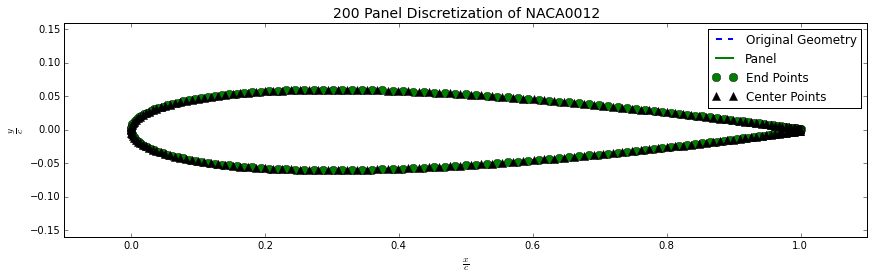

In [23]:
###############################################################################
### MAIN FUNCTION #############################################################
###############################################################################

#Plotting Constants
txt_lbl = 14                        #label fontsize
txt_ttl = 14                        #title fontsize
mkr = 8

"""
Run simulation for various amounts of panels
geometry --> what geometry to run
name --> string of geometry name
Vinf --> freestream velocity
alpha_deg --> angle of attack
n --> numbers of panels to discretize geometry into
"""

#INPUTS
geometry = 'naca0012.dat'
name = 'NACA0012'

Vinf = 1 #Freestream velocity
rho_inf = 1. #freestream density
alpha_deg = 10 #Angle of attack
#Number of panels
n = 200

#READ AIRFOIL DATA
xgeom, ygeom = ReadXfoilGeometry(geometry)

#INITIALIZE FREESTREAM CONDITIONS AND AIRFOIL PARAMETERS
missingpanel = 152
ihole = missingpanel - 1
airfoil = Airfoil(xgeom, ygeom, ihole, alpha_deg, Vinf, rho_inf, name)
airfoil.set_title_details(n)

#DISCRETIZE GEOMETRY INTO PANELS
panels = MakePanels(airfoil.xgeom, airfoil.ygeom, n, 'circle')

#SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
panels = SolveVorticity(panels, airfoil)


#PLOT PANEL GEOMETRY
PlotPanels(airfoil.xgeom, airfoil.ygeom, panels, airfoil.name, 1)

**Figure 1: 200 Panel Discretization of NACA0012 Airfoil**

Figure 1 shows the NACA0012 airfoil discretized by 200 panels in a circular spacing.

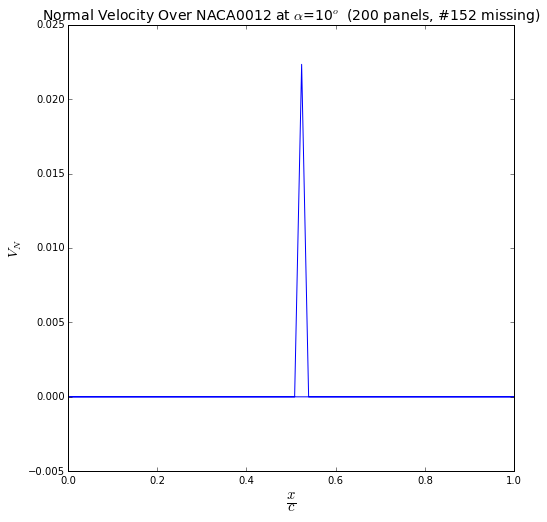

In [24]:
#Evaluates normal velocity
NormalVel(panels, airfoil, 1)

**Figure 2: Normal Velocity Over Surface of the Panels**

Figure 2 shows the normal velocity over the surface of the panels of the NACA 0012 airfoil. The missing panel causes a spike in the graph because the tangency condition is not enforced there. However, everywhere else, the tangency condition is enforced.

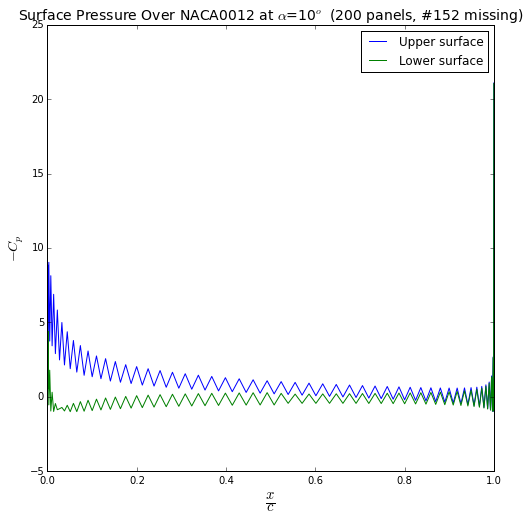

In [25]:
#Evaluates tangential velocity and pressure distribution
TangentVel(panels, airfoil, 0)
Panels_Cp(panels, airfoil, 1)

**Figure 3: Tangential Velocity Over Surface of the Panels**

Figure 3 shows the tangential velocity over the surface of the panels of the NACA 0012 airfoil. The oscillations are due to the oscillatory behavior of the resultant vortex strengths from applying the tangency condition.

In [26]:
#Calculates the circulation using various methods
#Circle centered x=0.5,y=0 with radius 5
gam_circ1 = Gamma_Circle(panels,airfoil,5,0.5,0,1000)
gam_circ2 = Gamma_Circle(panels,airfoil,5,0.5,0,1000,2)
#Square centered x=0.5,y=0 with side lengths 10
gam_square1 = Gamma_Square(panels,airfoil,10,0.5,0,250)
gam_square2 = Gamma_Square(panels,airfoil,10,0.5,0,250,2)


gam_act = sum([p.gamma*p.length for p in panels])

In [27]:
#Calculates the lift coefficient
cl_circ1 = 2*gam_circ1/airfoil.Vinf
cl_square1 = 2*gam_square1/airfoil.Vinf
cl_circ2 = 2*gam_circ2/airfoil.Vinf
cl_square2 = 2*gam_square2/airfoil.Vinf

cl_pres = Cl(panels,airfoil)

cl_act = 2*gam_act/airfoil.Vinf

In [28]:
print('Lift coefficient using circulation from a circle (Vector dot product):', cl_circ1)
print('Lift coefficient using circulation from a square (Vector dot product):', cl_square1)
print('Lift coefficient using circulation from a circle (2 Vector dot product relation):', cl_circ2)
print('Lift coefficient using circulation from a square (2 Vector dot product relation):', cl_square2)


Lift coefficient using circulation from a circle (Vector dot product): 0.604078461672
Lift coefficient using circulation from a square (Vector dot product): 0.604843354158
Lift coefficient using circulation from a circle (2 Vector dot product relation): 0.615748638889
Lift coefficient using circulation from a square (2 Vector dot product relation): 0.524988446336


In [29]:
print('Lift coefficient using surface pressures:',cl_pres)
print('Lift coefficient using circulation from panels\' vortex strength:',cl_act)

Lift coefficient using surface pressures: 1.1848879662
Lift coefficient using circulation from panels' vortex strength: 1.20816488866


From the results, the circulation calculated using a closed loop is giving roughly half of the actual circulation generated by the vortex panels. The vector dot product method is more accurate than the 2D dot product definition method because the vector dot product method produced results that are exactly half of the actual circulation.

The process for circulation requires the vortex strength distribution, the x-y velocities, and the circulation integral to be computed. The vortex strength distribution is not wrong because the lift coefficient form the vortex strengths matches with XFOIL very well. The circulation integral should not be wrong because I used four methods to compute it and got the same results. The culprit is most likely the x-y velocities, but the equations are properly derived. In any case, the circulation through the line integral is off by a factor of 2. I suggest a second order vortex panel method to be used.

On the other hand, the lift coefficient from the surface pressures matches well with the actual lift coefficient from the vortex strengths. Therefore, this panel method is still viable for calculations of lift if the surface pressures are used or if the vortex strengths are used.

---

### Problem 2: Aerodynamic Analysis With Vortex Panels

#### Approach

Lifting flow across the airfoils are again modeled using vortex panels. A plot of the lift coefficient versus the location of the missing panel can be generated through iteration. First the location of the missing panel is set. Then panels are generated with the vortex strengths calculated. Lastly, the lift coefficient can be calculated using the distribution of vortex strengths and the Kutta-Joukowski Theorem. Repeating this with different locations of the missing panel results in the desired plot.

The velocity streamlines can be plotted by using a meshgrid and calculate the x-y velocity components across the grid. The surface pressure distribution is obtained in the same was as Problem 1. The lift curve slope can be found by finding the lift coefficient at two angle of attacks. The lift curve slope is then the difference of the lift coefficients divided by the difference of the angle of attacks.

#### Equations

When given the vortex strength per unit length of each panel, the total circulation from the panels can be calculated by summing the vortex strength over each panel using the following equation.

$$
\Gamma = \sum_{j=1}^n \gamma_j s_j
$$

$\gamma_j$ is the vortex strength per unit length and $s_j$ is the total length of the panel.

And the lift coefficient derived from the Kutta-Joukowski Theorem is

$$
C_l = \frac{2\Gamma}{V_\infty}
$$

This equation will be used to calculate the lift coefficient for each part.

Slope of the lift curve obtained through Thin Airfoil Theory.

$$
\frac{dC_l}{d\alpha} = 2\pi
$$

This slope applies to both a cambered airfoil and a symmetric airfoil.

#### Code and Results

In [72]:
#INPUTS
data1 = 'naca0012.dat'
name1 = 'NACA0012'

data2 = 'naca24012.dat'
name2 = 'NACA24012'

#Load xfoil data
xf_x0012, xf_Cp0012_a00 = np.genfromtxt('NACA0012_a00.dat',skip_header=1,unpack=True)
xf_x0012, xf_Cp0012_a10 = np.genfromtxt('NACA0012_a10.dat',skip_header=1,unpack=True)

xf_x24012, xf_Cp24012_a00 = np.genfromtxt('NACA24012_a00.dat',skip_header=1,unpack=True)
xf_x24012, xf_Cp24012_a10 = np.genfromtxt('NACA24012_a10.dat',skip_header=1,unpack=True)

In [73]:
#Properties
Vinf = 1 #Freestream velocity
rho_inf = 1. #freestream density
alpha_deg = 0 #Angle of attack
#Number of panels
n = 100

#Initialize
Cl_hole = np.empty((n,1),dtype=float)

#READ AIRFOIL DATA
x24012, y24012 = ReadXfoilGeometry('naca24012.dat')
x0012, y0012 = ReadXfoilGeometry('naca0012.dat')
#INITIALIZE FREESTREAM CONDITIONS AND AIRFOIL PARAMETERS
NACA24012 = Airfoil(x24012, y24012, 0, alpha_deg, Vinf, rho_inf, 'NACA24012')
NACA24012.set_title_details(n)
NACA0012 = Airfoil(x0012, y0012, 0, alpha_deg, Vinf, rho_inf, 'NACA0012')
NACA0012.set_title_details(n)

Iteration for lift coefficient versus missing panel plot:

In [385]:
for i in range(0,n):
    #Sets missing panel location
    ihole = i
    NACA24012.set_ihole(ihole)

    #DISCRETIZE GEOMETRY INTO PANELS
    panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')
    
    #SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
    panels24012 = SolveVorticity(panels24012, NACA24012)
    
    Gamma = sum([p.gamma*p.length for p in panels24012])
    
    #Evaluate Cl using vortex strengths
    Cl_hole[i] = 2*Gamma/NACA24012.Vinf
    

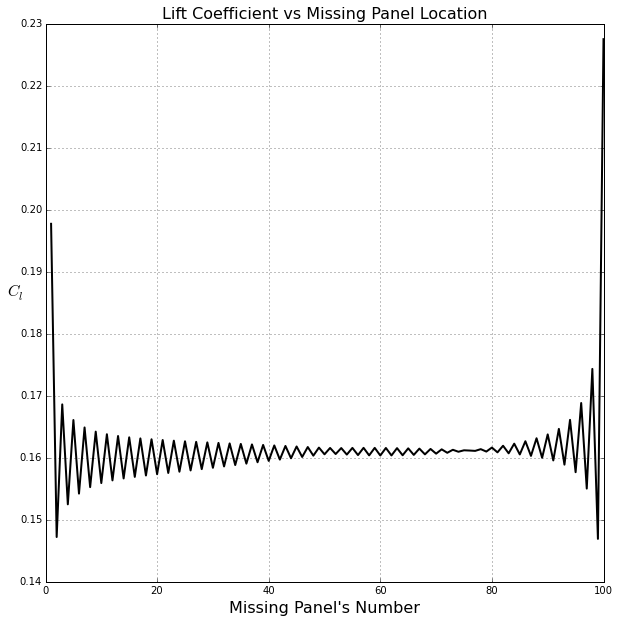

In [386]:
size = 10
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('Missing Panel\'s Number', fontsize=16)
plt.ylabel('$C_l$', fontsize=16,rotation='horizontal')
plt.plot(range(1,n+1), Cl_hole, color='k', linestyle='-', linewidth=2)
plt.title('Lift Coefficient vs Missing Panel Location', fontsize=16);

**Figure 4: Lift Coefficient versus Missing Panel Location**

From Figure 4, the best location for the missing panel is at panel number 76 (index 75) which has a normalized chordwise position $\left(\frac{x}{c},\frac{y}{c}\right)$ of (0.5157, -0.003881) because the lift coefficient oscillates the least than in other areas. Less oscillations mean that the missing panel is not inducing a lot of change at that location.

The worst locations for the missing panel are at index 0 and index 100 which are at the trailing edge because the lift coefficient is overestimated.

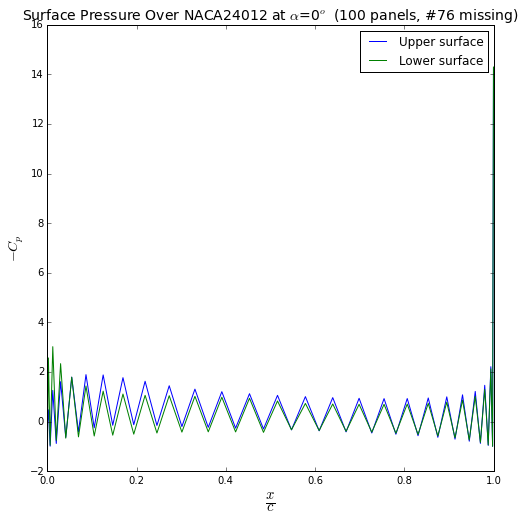

In [403]:
#Sets missing panel location
ihole = 75
NACA24012.set_ihole(ihole)

#FIGURE TITLES
NACA24012.set_title_details(n)


#DISCRETIZE GEOMETRY INTO PANELS
panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')

#SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
panels24012 = SolveVorticity(panels24012, NACA24012)
#Evaluates velocities, and Cp
TangentVel(panels24012, NACA24012, 0)
Panels_Cp(panels24012, NACA24012, 1)

**Figure 5: Surface Pressure Over NACA24012 At $0^o$ Angle of Attack With Panel 76 Missing**

Figure 5 shows the surface pressure distribution without enforcing the tangency condition at Panel number 76.

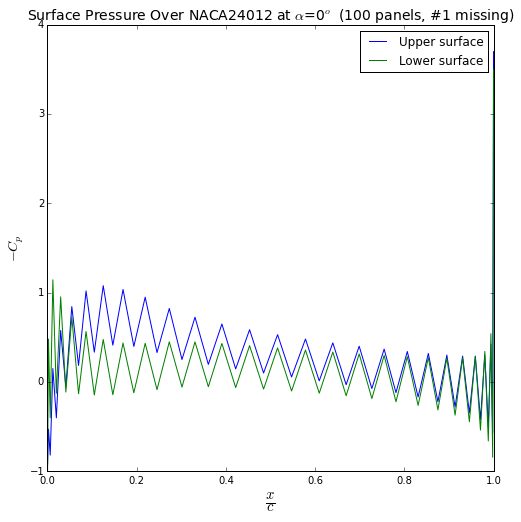

In [380]:
#Sets missing panel location
ihole = 0
NACA24012.set_ihole(ihole)

#FIGURE TITLES
NACA24012.set_title_details(n)


#DISCRETIZE GEOMETRY INTO PANELS
panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')

#SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
panels24012 = SolveVorticity(panels24012, NACA24012)
#Evaluates velocities, and Cp
TangentVel(panels24012, NACA24012, 0)
Panels_Cp(panels24012, NACA24012, 1)


**Figure 6: Surface Pressure Over NACA24012 At $0^o$ Angle of Attack With Panel 1 Missing**

Figure 6 shows the surface pressure distribution without enforcing the tangency condition at Panel number 1.

In comparison with the other figure, the upper surface pressure is much lower than the upper surface with panel 76 missing. Specifically, the upper surface pressure's maximums and minimums with panel 1 missing is offset from the lower surface pressure much more than the upper surface pressure's maximums and minimums with panel 76 missing. This causes the spikes at the ends of the lift coefficient graph because a greater difference between the upper surface pressure and lower surface pressure results in a greater lift coefficient. On the other hand, the surface pressures with panel 76 missing has a higher absolue maximum value from the way the plot is scaled to fit the data. But this spike does not affect lift coefficient between both upper and lower surface pressures decrease at the same rate.

If the angle of attack is changed, the best missing panel location would be the same. The lift coefficient versus missing panel plot shows the relative magnitude of the lift coefficient with the missing panel at different locations. The angle of attack will change the lift coefficient but the entire plot will scale with the change in angle of attack, leaving the best missing panel location at the the same location.

In [466]:
#Sets missing panel location
ihole = 75
NACA24012.set_ihole(ihole)
NACA0012.set_ihole(ihole)

#Set angle of attack
NACA24012.set_alpha(10)
NACA0012.set_alpha(10)

#FIGURE TITLES
NACA24012.set_title_details(n)
NACA0012.set_title_details(n)

#DISCRETIZE GEOMETRY INTO PANELS
panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')
panels0012 = MakePanels(NACA0012.xgeom, NACA0012.ygeom, n, 'circle')

#SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
panels24012 = SolveVorticity(panels24012, NACA24012)
panels0012 = SolveVorticity(panels0012, NACA0012)

In [459]:
#Initialize Mesh
N_grid = 100                              # Number of points in each direction
x_0, x_f = -0.5, 1.5            # x-direction boundaries
y_0, y_f = -0.5, 0.5            # y-direction boundaries
x = np.linspace(x_0, x_f, N_grid)    # 1D-array for x
y = np.linspace(y_0, y_f, N_grid)    # 1D-array for y
X, Y = np.meshgrid(x, y)              # generates a mesh grid

In [460]:
#Obtains the velocity field generated by the NACA 0012 Panels
U0012, V0012 = Panel_VFD(panels0012, X, Y)

U0012 = U0012 + NACA0012.Vinf*np.cos(NACA0012.alpha) #Adds the free stream contribution
V0012 = V0012 + NACA0012.Vinf*np.sin(NACA0012.alpha)


In [461]:
#Obtains the velocity field generated by the NACA 24012 Panels
U24012, V24012 = Panel_VFD(panels24012, X, Y)

U24012 = U24012 + NACA24012.Vinf*np.cos(NACA24012.alpha) #Adds the free stream contribution
V24012 = V24012 + NACA24012.Vinf*np.sin(NACA24012.alpha)


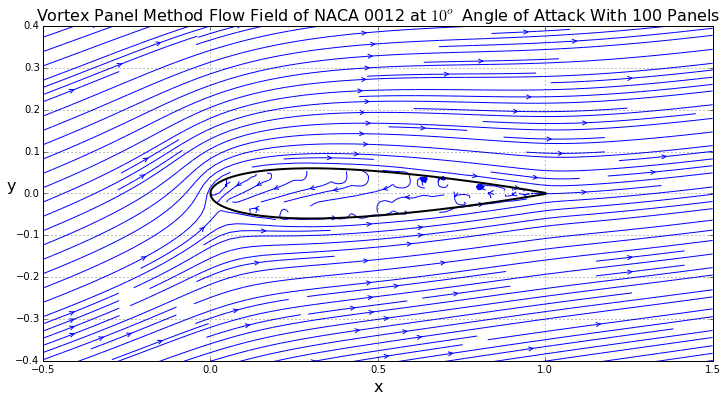

In [464]:
# Plotting flow field and Cp contours
size = 12
plt.figure(figsize=(size, size/2))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16,rotation='horizontal')
plt.plot(x0012, y0012, color='k', linestyle='-', linewidth=2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.4, 0.4);
plt.streamplot(X, Y, U0012, V0012, density=2, linewidth=1, arrowsize=1, arrowstyle='->');
plt.title('Vortex Panel Method Flow Field of NACA 0012 at $10^o$ Angle of Attack With 100 Panels', fontsize=16);

**Figure 7: Vortex Panel Method Flow Field of NACA 0012 at $10^o$ Angle of Attack With 100 Panels**

Figure 7 shows the flow field of a NACA 0012 airfoil. The Kutta condition is well maintained because there is a streamline coming out of the trailing edge of the airfoil. On the other hand, flow tangency is maintained at most locations but not some. The location where flow tangency is not maintained is near the panel where the tangency condition is not enforced. In other areas of the airfoil, flow tangency is well maintained.

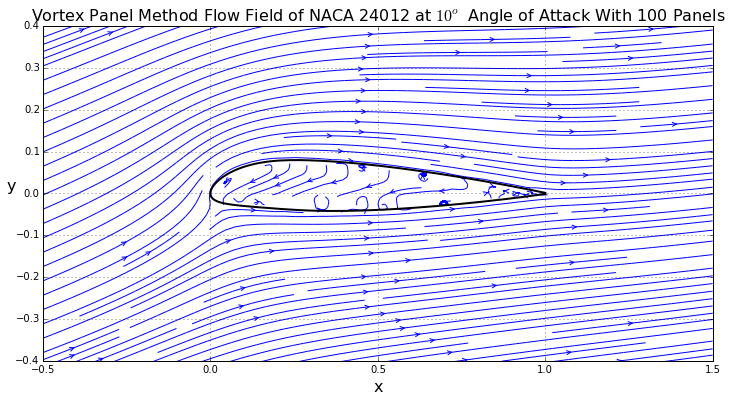

In [465]:
# Plotting flow field and Cp contours
size = 12
plt.figure(figsize=(size, size/2))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16,rotation='horizontal')
plt.plot(x24012, y24012, color='k', linestyle='-', linewidth=2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.4, 0.4);
plt.streamplot(X, Y, U24012, V24012, density=2, linewidth=1, arrowsize=1, arrowstyle='->');
plt.title('Vortex Panel Method Flow Field of NACA 24012 at $10^o$ Angle of Attack With 100 Panels', fontsize=16);

**Figure 8: Vortex Panel Method Flow Field of NACA 24012 at $10^o$ Angle of Attack With 100 Panels**

Figure 8 shows the flow field of a NACA 24012 airfoil. The Kutta condition seems to be well maintained because the surrounding streamlines around the trailing edge does not converge onto the line at the trailing edge. However, the plot does not depict a streamline coming out of the trailing edge. And again, flow tangency is maintained at most locations but not some. Like the NACA 0012 airfoil, the location where flow tangency is not maintained is near the panel where the tangency condition is not enforced. In other areas of the airfoil, flow tangency is actually maintained better than the NACA 24012 airfoil from how the velocity field is plotted.

Sets angle of attack and reinitializes panels:

In [484]:
#Set angle of attack
NACA24012.set_alpha(0)
NACA0012.set_alpha(0)

#FIGURE TITLES
NACA24012.set_title_details(n)
NACA0012.set_title_details(n)

#DISCRETIZE GEOMETRY INTO PANELS
panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')
panels0012 = MakePanels(NACA0012.xgeom, NACA0012.ygeom, n, 'circle')

#SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
panels24012 = SolveVorticity(panels24012, NACA24012)
panels0012 = SolveVorticity(panels0012, NACA0012)

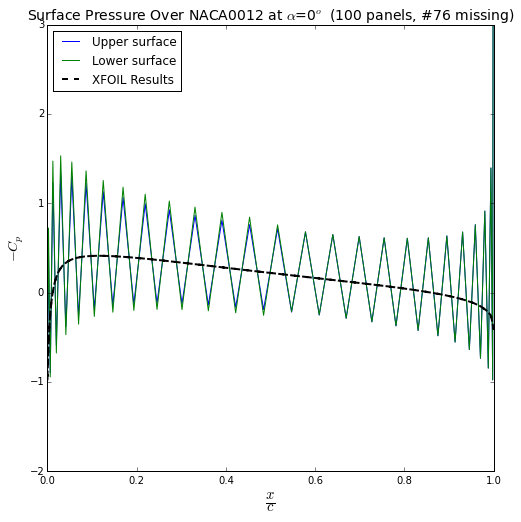

In [492]:
#Evaluates velocities, and Cp
TangentVel(panels0012, NACA0012)
Panels_Cp(panels0012, NACA0012)

size = 8
plt.figure(figsize = (size,size))
plt.title('Surface Pressure Over ' + NACA0012.title, fontsize=txt_ttl)
plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
plt.ylabel('$-C_p$', fontsize=txt_lbl)
plt.plot([p.xc for p in panels0012 if p.surf=='upper'], [-p.cp for p in panels0012 if p.surf=='upper'], label = 'Upper surface')
plt.plot([p.xc for p in panels0012 if p.surf=='lower'], [-p.cp for p in panels0012 if p.surf=='lower'], label = 'Lower surface')
plt.plot(xf_x0012, -xf_Cp0012_a00, label = 'XFOIL Results', linestyle = '--', linewidth = 2, color = 'k')
plt.legend(loc='best');
plt.ylim([-2,3]);

**Figure 9: Surface Pressure of NACA 0012 at $0^o$ Angle of Attack**

Figure 9 shows the surface pressure of the NACA 0012 airfoil at 0 angle of attack. The green and blue lines are the surface pressure results from the vortex panel method. The black dashed line shows the results from XFOIL. If the surface pressure results from the vortex panel is averaged between the sets of two points next to each other, the result would form a curve that closely fits the XFOIL results.

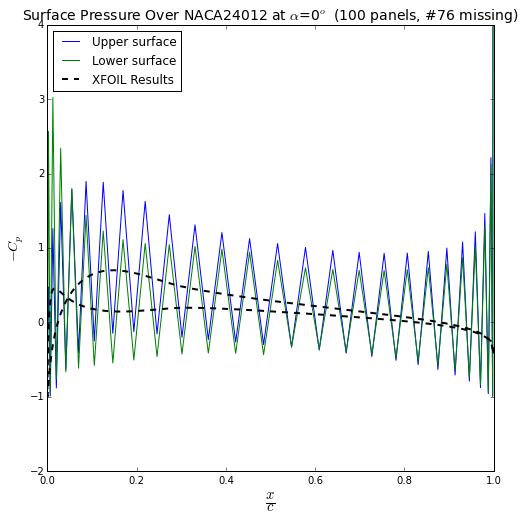

In [493]:
#Evaluates velocities, and Cp
TangentVel(panels24012, NACA24012)
Panels_Cp(panels24012, NACA24012)

size = 8
plt.figure(figsize = (size,size))
plt.title('Surface Pressure Over ' + NACA24012.title, fontsize=txt_ttl)
plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
plt.ylabel('$-C_p$', fontsize=txt_lbl)
plt.plot([p.xc for p in panels24012 if p.surf=='upper'], [-p.cp for p in panels24012 if p.surf=='upper'], label = 'Upper surface')
plt.plot([p.xc for p in panels24012 if p.surf=='lower'], [-p.cp for p in panels24012 if p.surf=='lower'], label = 'Lower surface')
plt.plot(xf_x24012, -xf_Cp24012_a00, label = 'XFOIL Results', linestyle = '--', linewidth = 2, color = 'k')
plt.legend(loc='best');
plt.ylim([-2,4]);

**Figure 10: Surface Pressure of NACA 24012 at $0^o$ Angle of Attack**

Figure 10 shows the surface pressure of the NACA 24012 airfoil at 0 angle of attack. The green and blue lines are the surface pressure results from the vortex panel method. The black dashed line shows the results from XFOIL. Again, if the surface pressure results from the vortex panel is averaged between the sets of two points next to each other, the result would form a curve that closely fits the XFOIL results.

Sets new angle of attack and reinitializes panels:

In [494]:
#Set angle of attack
NACA24012.set_alpha(10)
NACA0012.set_alpha(10)

#FIGURE TITLES
NACA24012.set_title_details(n)
NACA0012.set_title_details(n)

#DISCRETIZE GEOMETRY INTO PANELS
panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')
panels0012 = MakePanels(NACA0012.xgeom, NACA0012.ygeom, n, 'circle')

#SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
panels24012 = SolveVorticity(panels24012, NACA24012)
panels0012 = SolveVorticity(panels0012, NACA0012)

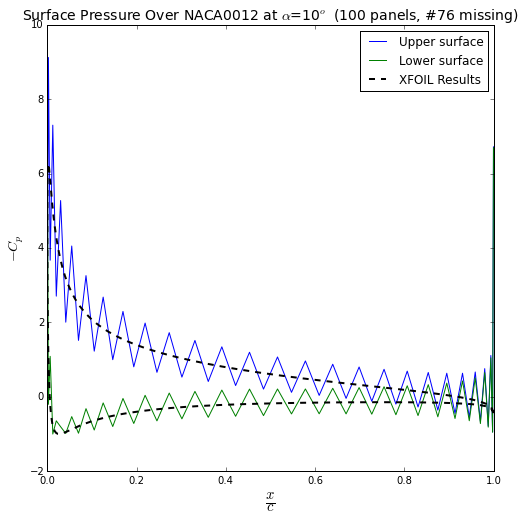

In [495]:
#Evaluates velocities, and Cp
TangentVel(panels0012, NACA0012)
Panels_Cp(panels0012, NACA0012)

size = 8
plt.figure(figsize = (size,size))
plt.title('Surface Pressure Over ' + NACA0012.title, fontsize=txt_ttl)
plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
plt.ylabel('$-C_p$', fontsize=txt_lbl)
plt.plot([p.xc for p in panels0012 if p.surf=='upper'], [-p.cp for p in panels0012 if p.surf=='upper'], label = 'Upper surface')
plt.plot([p.xc for p in panels0012 if p.surf=='lower'], [-p.cp for p in panels0012 if p.surf=='lower'], label = 'Lower surface')
plt.plot(xf_x0012, -xf_Cp0012_a10, label = 'XFOIL Results', linestyle = '--', linewidth = 2, color = 'k')
plt.legend(loc='best');


**Figure 11: Surface Pressure of NACA 0012 at $10^o$ Angle of Attack**

Figure 11 shows the surface pressure of the NACA 0012 airfoil at 10 angle of attack. The green and blue lines are the surface pressure results from the vortex panel method. The black dashed line shows the results from XFOIL. At this angle of attack, the fit between XFOIL data and the vortex panel method data is easier to see. If the surface pressure results from the vortex panel is averaged between the sets of two points next to each other, the result would form a curve that closely fits the XFOIL results.

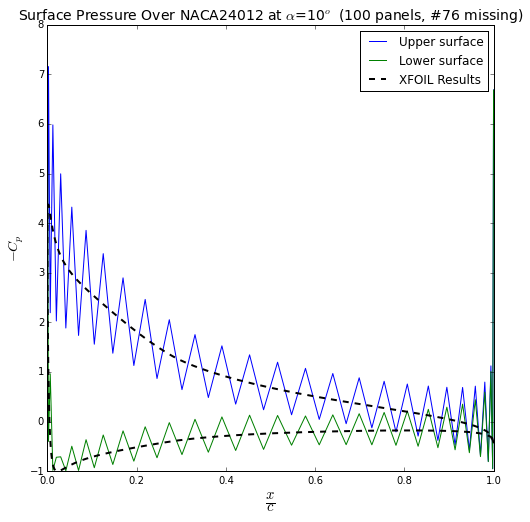

In [496]:
#Evaluates velocities, and Cp
TangentVel(panels24012, NACA24012)
Panels_Cp(panels24012, NACA24012)

size = 8
plt.figure(figsize = (size,size))
plt.title('Surface Pressure Over ' + NACA24012.title, fontsize=txt_ttl)
plt.xlabel(r'$\frac{x}{c}$', fontsize=txt_lbl*1.5)
plt.ylabel('$-C_p$', fontsize=txt_lbl)
plt.plot([p.xc for p in panels24012 if p.surf=='upper'], [-p.cp for p in panels24012 if p.surf=='upper'], label = 'Upper surface')
plt.plot([p.xc for p in panels24012 if p.surf=='lower'], [-p.cp for p in panels24012 if p.surf=='lower'], label = 'Lower surface')
plt.plot(xf_x24012, -xf_Cp24012_a10, label = 'XFOIL Results', linestyle = '--', linewidth = 2, color = 'k')
plt.legend(loc='best');

**Figure 12: Surface Pressure of NACA 24012 at $10^o$ Angle of Attack**

Figure 12 shows the surface pressure of the NACA 24012 airfoil at 10 angle of attack. The green and blue lines are the surface pressure results from the vortex panel method. The black dashed line shows the results from XFOIL. Similar to the last plot, if the surface pressure results from the vortex panel is averaged between the sets of two points next to each other, the result would form a curve that closely fits the XFOIL results.

For each case, vortex panel method accurately shows that a cambered airfoil generates more lift than a symmetric airfoil at the same angle of attack. At the higher angle of attack, the upper surface pressure for the cambered airfoil is not as steep as the upper surface pressure for the symmetric airfoil, allowing a larger area between the upper surface pressure and the lower surface pressure and resulting in a larger coefficient of lift. At a zero angle of attack, the symmetric airfoil does not generate any lift because the upper surface pressure and lower surface pressure are almost exactly the same. On the other hand, the cambered airfoil does generate lift due to the difference between upper surface pressure and lower surface pressure. However, the cambered airfoil at zero angle of attack has a downward lift near the leading edge where the upper surface pressure is higher than the lower surface pressure.

In [85]:
#Range for alpha
alpha_i = 1
alpha_i1 = 5
alpha = [alpha_i, alpha_i1]
Cl_alpha_24012 = [0,0]
Cl_alpha_0012 = [0,0]

#Find the Cl values at the two alpha's
for i in range(0,2):
    NACA24012.set_alpha(alpha[i])
    #DISCRETIZE GEOMETRY INTO PANELS
    panels24012 = MakePanels(NACA24012.xgeom, NACA24012.ygeom, n, 'circle')

    #SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
    panels24012 = SolveVorticity(panels24012, NACA24012)

    Gamma24012 = sum([p.gamma*p.length for p in panels24012])

    #Evaluate Cl using vortex strengths
    Cl_alpha_24012[i] = 2*Gamma24012/NACA24012.Vinf
    
    NACA0012.set_alpha(alpha[i])
    #DISCRETIZE GEOMETRY INTO PANELS
    panels0012 = MakePanels(NACA0012.xgeom, NACA0012.ygeom, n, 'circle')

    #SOLVE FOR PANEL STRENGTH DISTRIBUTIONS
    panels0012 = SolveVorticity(panels0012, NACA0012)

    Gamma0012 = sum([p.gamma*p.length for p in panels0012])

    #Evaluate Cl using vortex strengths
    Cl_alpha_0012[i] = 2*Gamma0012/NACA0012.Vinf

dCl_dalpha_0012 = (Cl_alpha_0012[1] - Cl_alpha_0012[0])/((alpha_i1-alpha_i)*(np.pi/180))
dCl_dalpha_24012 = (Cl_alpha_24012[1] - Cl_alpha_24012[0])/((alpha_i1-alpha_i)*(np.pi/180))

In [86]:
print('Lift Curve Slope with Vortex Panels (NACA0012):', dCl_dalpha_0012)
print('Lift Curve Slope with Vortex Panels (NACA24012):', dCl_dalpha_24012)
print('Lift Curve Slope with Thin Airfoil Theory:', 2*np.pi)

Lift Curve Slope with Vortex Panels: 6.86806873148
Lift Curve Slope with Vortex Panels: 6.8838070456
Lift Curve Slope with Thin Airfoil Theory: 6.283185307179586


The lift curve slope with the vortex panels between the symmetric and cambered airfoil is almost the same. This agrees with Thin Airfoil Theory where the lift curve slope of a symmetric airfoil and a cambered airfoil is exactly 2$\pi$. Varying the angle of attack does not change the lift curve slope by a lot, indicating that the lift curve slope is constant, also agreeing with Thin Airfoil Theory. However, the vortex panel method obtains a lift curve slope that is about 0.6 higher than 2$\pi$. 

---

## Conclusion

The first order vortex panel method gives a correct circulation to provide lift in a potential flow. This method generates the correct vortex strengths corresponding to the correct lift coefficient. But this method only generates a somewhat correct surface pressure distribution for both a symmetric airfoil and a cambered airfoil. The problem is that the first order method computes an oscillatory vortex strength distribution which results in a oscillatory surface pressure distribution. Correcting the oscillatory behavior of the pressure distribution will require an averaging operation between points, leading to errors. In addition, the first order method does not enforce the tangency condition at one panel in order to enforce the Kutta condition. In the end, this will create even more errors. The errors can be seen by comparing the lift curve slope with the lift curve slope from Thin Airfoil theory. To decrease the amount of errors, I suggest a higher order vortex panel method to be used, or a source-vortex panel method to be used, where tangency and the Kutta condition can be enforced correctly.